# Исследование рынка заведений общественного питания Москвы

## Задача

Подготовить исследование рынка заведений общественного питания Москвы на основе открытых данных. Заказчик: инвесторы потенциального кафе в Москве, где гостей должны обслуживать роботы.

## Описание данных

Таблица **rest_data**:

- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — индикатор сетевого заведения;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

## Оглавление

### [Шаг 1. Загрузка данных и подготовка их к анализу](#data_preparation)

### [Шаг 2. Анализ данных](#data_analysis)
1. [Исследование соотношения видов объектов общественного питания по количеству](#1)
2. [Исследование соотношения сетевых и несетевых заведений по количеству](#2)
3. [Для какого вида объекта общественного питания характерно сетевое распространение?](#3)
4. [Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?](#4)
5. [Среднее количество посадочных мест для каждого вида объекта общественного питания](#5)
6. [Информация об улице](#6)
7. [Топ-10 улиц по количеству объектов общественного питания. В каких районах Москвы находятся эти улицы?](#7)
8. [Число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?](#8)
9. [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Закономерности](#9)

### [Шаг 3.  Рекомендации](#recommendation)

## Ход работы

#### Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette('muted')
sns.set_style('dark')
import requests
from io import BytesIO
import warnings
warnings.simplefilter('ignore')

## <a id='data_preparation'>Шаг 1. Загрузка данных и подготовка их к анализу</a>

In [2]:
def review_file(filename):
    '''
    Функция сохраняет данные в возвращаемую переменную
    и выводит необходимую информацию на экран.
    
    Аргументы:
        filename (str): путь к файлу.
    '''
    
    table = pd.read_csv(filename)
    
    print('\033[1m'
          + 'Общая информация о таблице:'
          + '\033[0m')
    print()
    table.info()
    print()
    
    print('\033[1m'
          + 'Первые 10 строк таблицы:'
          + '\033[0m')
    display(table.head(10))
        
    print('\033[1m' +
          'Количество пропусков в каждом столбце таблицы:'
          + '\033[0m')
    display(pd.DataFrame(table.isna().sum()))
    
    print('\033[1m'
          + f'Число дубликатов в таблице: {table.duplicated().sum()}'
          + '\033[0m')
    
    return table

In [3]:
rest_data = review_file('/datasets/rest_data.csv')

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB

Первые 10 строк таблицы:


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


Количество пропусков в каждом столбце таблицы:


,0
id,0
object_name,0
chain,0
object_type,0
address,0
number,0


Число дубликатов в таблице: 0


In [4]:
print('Число заведений с совпадающими названиями и адресами: {:.0f}'
      .format(rest_data.duplicated(subset=['object_name', 'address']).sum()))

Число заведений с совпадающими названиями и адресами: 207


In [5]:
rest_data = rest_data.drop_duplicates(subset=['object_name', 'address'])

### Вывод

Датафрейм **rest_data** состоит из 15 366 строк и 6 столбцов. Пропусков нет. Типы данных корректны. Обнаружено 207 дубликатов (заведения, названия и адрес которых совпадают). Такие значения были удалены.

## <a id='data_analysis'>Шаг 2. Анализ данных</a>

### <a id='1'>1. Исследование соотношения видов объектов общественного питания по количеству</a>

In [6]:
def draw_bar(data, x, y, title, xlabel, ylabel, fontsize=20, 
             labelsize=20, orient='v', valuelabelformat='%.0f'):
    '''
    Функция выводит график столбчатой диаграммы с
    заданными параметрами.
    
    Аргументы:
        x (str): название столбца, отображаемого по абсциссе.
        
        y (str): название столбца, отображаемого по ординате.
        
        data (pandas.core.frame.DataFrame): таблица с данными.
        
        orient (str): вертикальная диаграмма ('v') или горизонатльная ('h').
        
        title (str): заголовок диаграммы.
        
        xlabel (str): подпись оси абсцисс.
        
        ylabel (str): подпись оси ординат.
        
        fontsize (int): размер шрифта.
        
        labelsize (int): размер меток.
        
        valuelabelformat (str): формат меток значений.
    '''
    
    plt.figure(figsize=(20, 12))
    ax = sns.barplot(
        x=x, 
        y=y, 
        data=data, 
        orient=orient
    )

    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    if orient == 'v':
        for rect in ax.patches:
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_height(),
                valuelabelformat % rect.get_height(),
                fontsize=fontsize,
                ha='center'
            )
    else:
        for rect in ax.patches:
            ax.text(
                rect.get_width(), 
                rect.get_y() + rect.get_height() / 2, 
                valuelabelformat % rect.get_width(),
                fontsize=fontsize,
                va='center'
            )
    plt.show()

In [7]:
def draw_pie(data, title, legendtitle, values_col, labels_col):
    '''
    Функция выводит график круговой диаграммы с
    заданными параметрами.
    
    Аргументы:
        data (pandas.core.frame.DataFrame): таблица с данными.
        
        title (str): заголовок диаграммы.
        
        values_col (str): столбец со значениями.
        
        labels_col (str): столбец с метками.
    '''
    
    plt.figure(figsize=(10, 20))
    plt.title(title)
    patches, labels, pct_texts = plt.pie(data[values_col], 
                                         autopct='%.1f%%', 
                                         textprops={
                                             'fontsize': 16, 
                                             'color': 'w'
                                         },
                                         rotatelabels=True)
    for label, pct_text in zip(labels, pct_texts):
        pct_text.set_rotation(label.get_rotation())
    plt.legend(title=legendtitle, 
               loc='upper left', 
               bbox_to_anchor=(1, 0, 0.5, 1), 
               labels=data[labels_col])
    plt.show()

In [8]:
object_type_data = (
    rest_data
    .groupby('object_type', as_index=False)
    .agg({'id': 'count', 'number': 'median'})
    .sort_values(by='id', ascending=False)
    .rename(columns={
        'id': 'object_amount',
        'number': 'seat_median'
    })
)

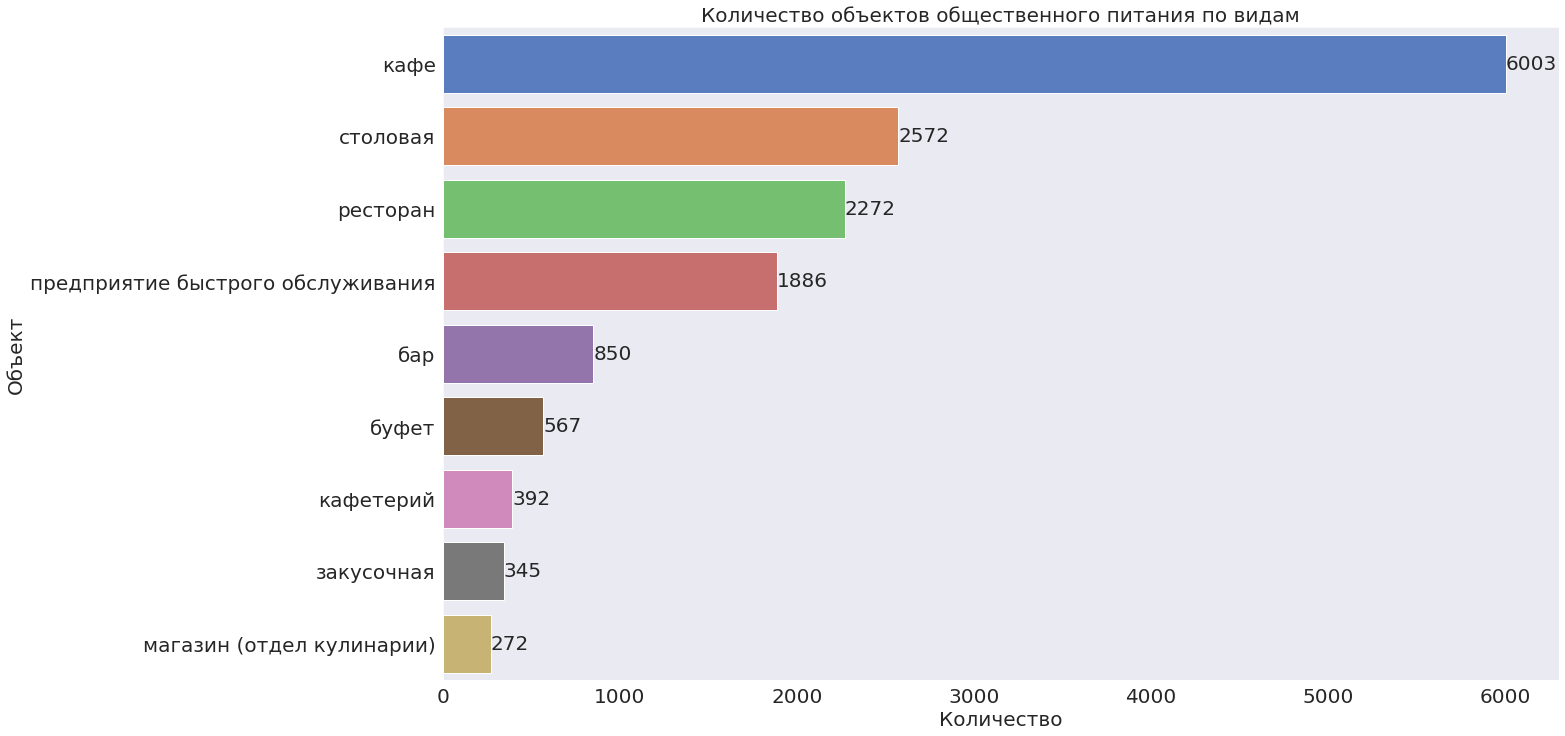

In [9]:
draw_bar(
    data=object_type_data, 
    x='object_amount', 
    y='object_type', 
    title='Количество объектов общественного питания по видам', 
    xlabel='Количество', 
    ylabel='Объект', 
    orient='h'
)

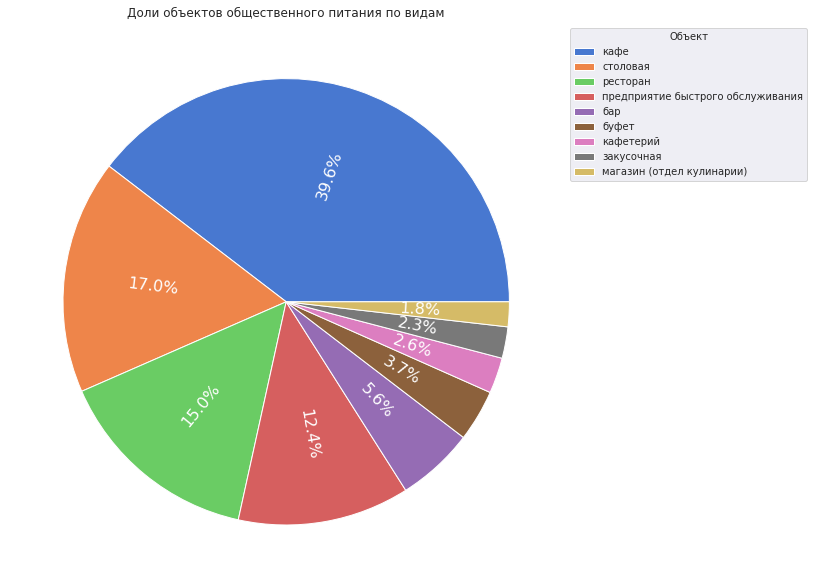

In [10]:
draw_pie(
    data=object_type_data, 
    title='Доли объектов общественного питания по видам',
    legendtitle='Объект',
    values_col='object_amount',
    labels_col='object_type'
)

Кафе — самый популярный объект общественного питания. Их количество превышает 6 000 и составляет почти 40% всех заведений.

Далее располагаются столовые, рестораны и предприятия быстрого обслуживания с показателями 2 572 (17%), 2 272 (15%) и 1 886 (12%) заведений соответственно.

Количество остальных типов объектов не превышает значения в 1 000 (менее 6%).

### <a id='2'>2. Исследование соотношения сетевых и несетевых заведений по количеству</a>

In [11]:
chain_data = (
    rest_data
    .groupby('chain', as_index=False)
    .agg({'id': 'count'})
    .sort_values(by='id', ascending=False)
    .rename(columns={
        'id': 'chain_amount'
    })
)

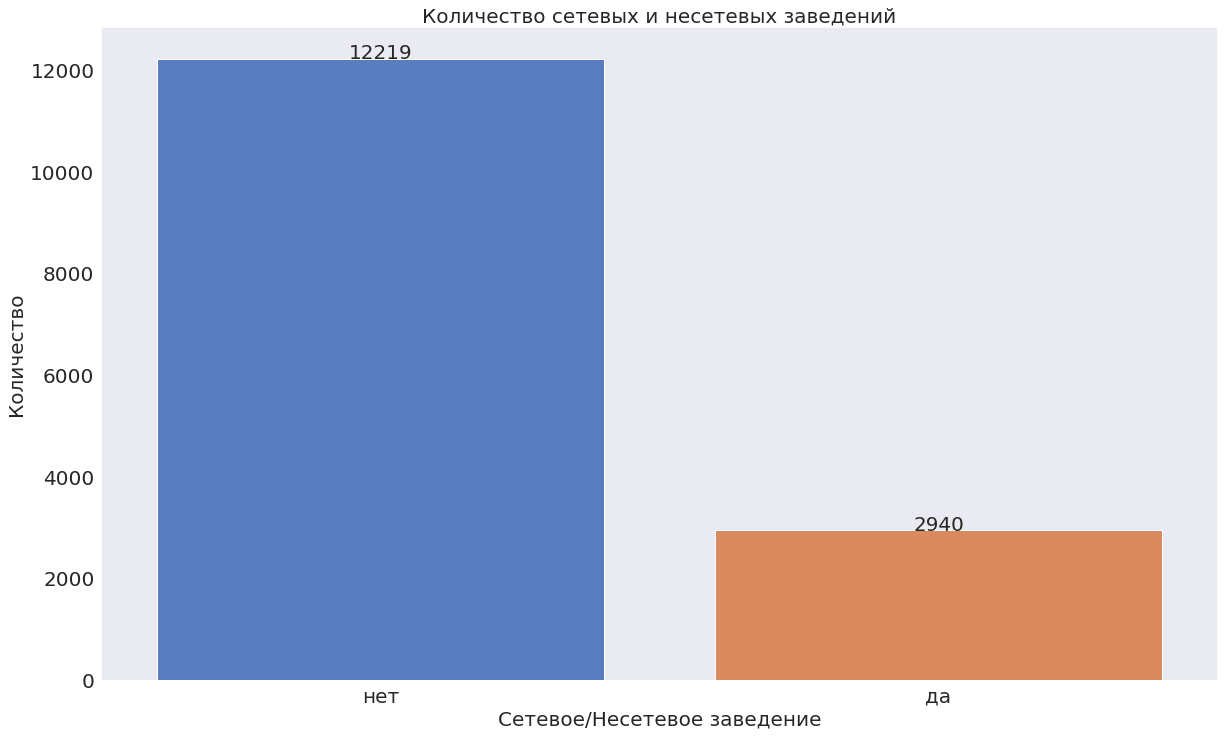

In [12]:
draw_bar(
    data=chain_data, 
    x='chain', 
    y='chain_amount', 
    title='Количество сетевых и несетевых заведений', 
    xlabel='Сетевое/Несетевое заведение', 
    ylabel='Количество'
)

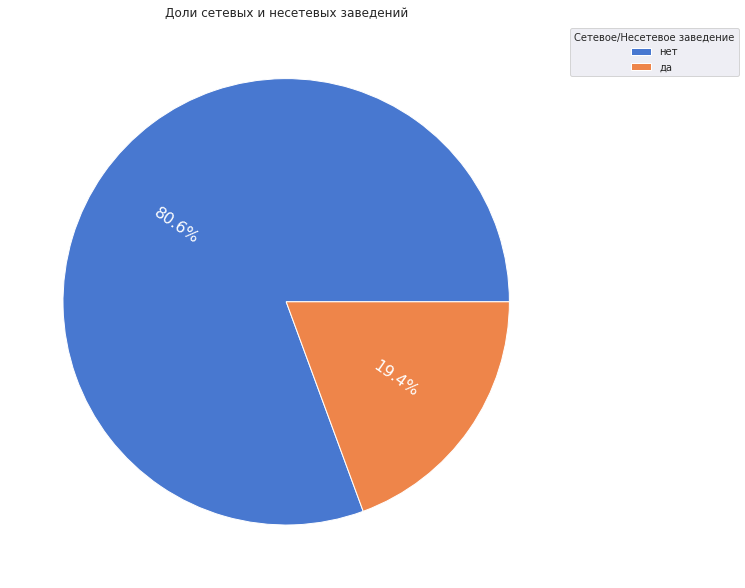

In [13]:
draw_pie(
    data=chain_data, 
    title='Доли сетевых и несетевых заведений',
    legendtitle='Сетевое/Несетевое заведение',
    values_col='chain_amount',
    labels_col='chain'
)

80% заведений не являются сетевыми.

### <a id='3'>3. Для какого вида объекта общественного питания характерно сетевое распространение?</a>

In [14]:
only_chain_data = rest_data.query('chain == "да"')

only_chain_object_type_data = (
    only_chain_data
    .groupby('object_type', as_index=False)
    .agg({'id': 'count'})
    .rename(columns={
        'id': 'chain_amount'
    })
    .merge(object_type_data, on='object_type')
)

only_chain_object_type_data['chain_ratio'] = (
    only_chain_object_type_data['chain_amount'] / only_chain_object_type_data['object_amount'] * 100
)

only_chain_object_type_data = (
    only_chain_object_type_data
    .sort_values(by='chain_ratio', ascending=False)
)

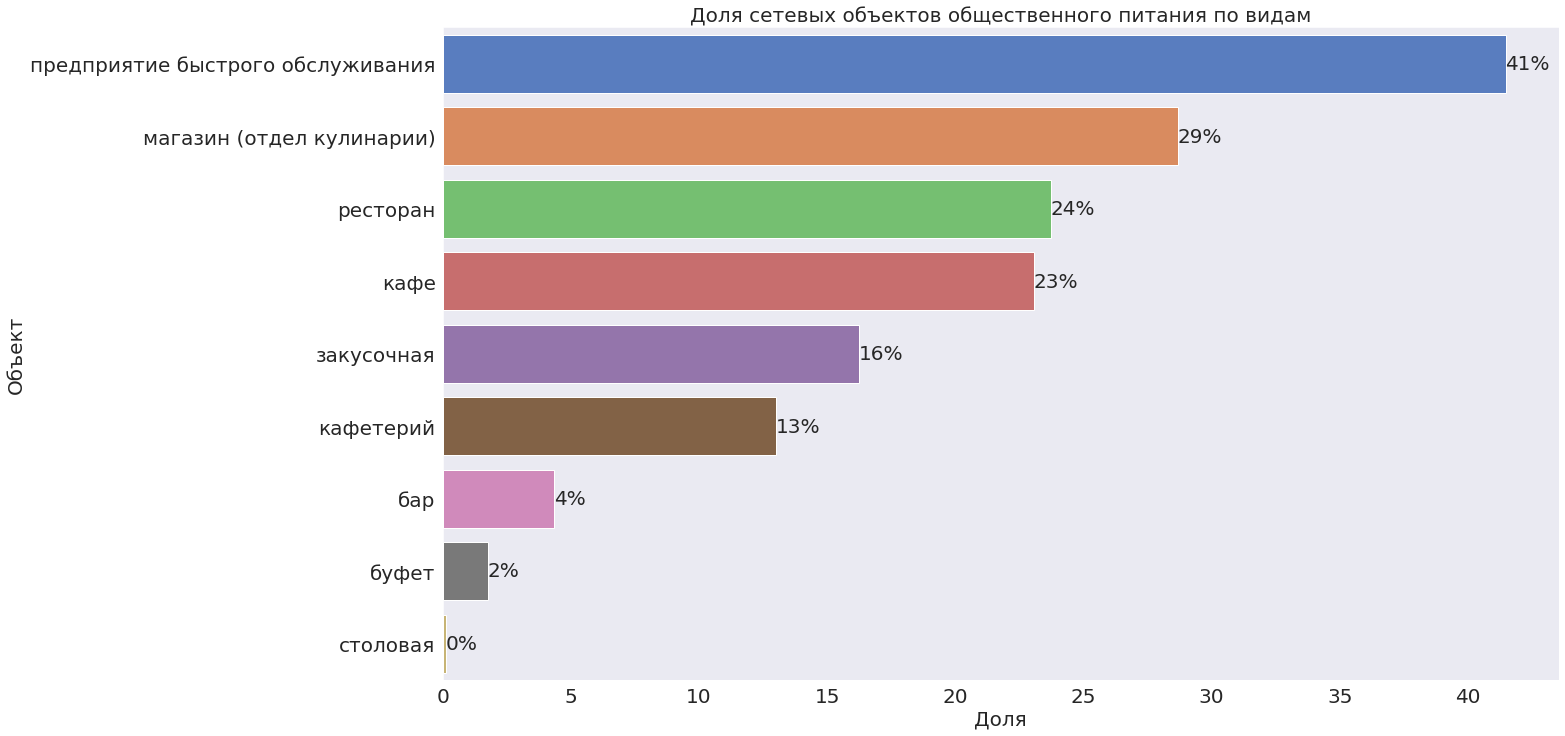

In [15]:
draw_bar(
    data=only_chain_object_type_data, 
    x='chain_ratio', 
    y='object_type', 
    title='Доля сетевых объектов общественного питания по видам', 
    xlabel='Доля', 
    ylabel='Объект',
    orient='h',
    valuelabelformat='%.0f%%'
)

Предприятия быстрого обслуживания в 41% случаев являются сетевыми. 29% кулинарных магазинов, 23-24% ресторанов и кафе также сетевые. Для остальных объектов общественного питания сетевая распространённость не особо характерна.

### <a id='4'>4. Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?</a>

In [16]:
def draw_boxplot(data, column, title, xlabel):
    '''
    Функция рисует диаграмму размаха соответствующего столбца датафрейма.
    
    Аргументы:
        data (pandas.core.frame.DataFrame): датафрейм.
        
        column (str): название столбца.
        
        title (str): заголовок.
        
        xlabel (str): подпись оси абсцисс.
    '''
    
    plt.figure(figsize=(15, 6))
    plt.boxplot(data[column],                              # по столбцу column датафрейма data
                notch=True,                                # формируем красивый "разрезик" в центре
                sym='o',                                   # задаем символ выброса 'o'
                vert=False,                                # располагаем горизонтально
                widths=0.1,                                # задаем толщину линий
                patch_artist=True)                         # применяем заливку
    # Настроим параметры делений
    plt.tick_params(which='major',                         # применим к основным делениям
                    direction='inout',                     # нарисуем деления внутри и снаружи графика
                    length=20,                             # длиной 20
                    width=4,                               # шириной 4
                    color='m',                             # цвета magenta
                    pad=10,                                # с расстоянием между делением и подписью 10
                    labelsize=15,                          # с размером подписи 15
                    labelcolor='r')                        # с тёмно-красным цветом подписи
    # Нарисуем медиану и перцентили
    plt.axvline(x=data[column].median(),                   # рисуем медиану
                linewidth=3,                               # с толщиной линий 3
                color='red',                               # красного цвета
                linestyle='--')                            # пунктирным стилем
    plt.axvline(x=data[column].quantile(.05),              # рисуем 5-ый перцентиль
                linewidth=3, 
                color='y',                                 # тёмно-жёлтого цвета
                linestyle='--')
    plt.axvline(x=data[column].quantile(.95),              # рисуем 95-ый перцентиль
                linewidth=3, 
                color='y', 
                linestyle='--')
    plt.grid(axis='x')
    plt.legend(labels=['_hidden_label', '_hidden_label', '_hidden_label', 
                       '_hidden_label', '_hidden_label', '_hidden_label', 
                       'Медиана', '5-ый и 95-ый перцентили'], fontsize=12)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()

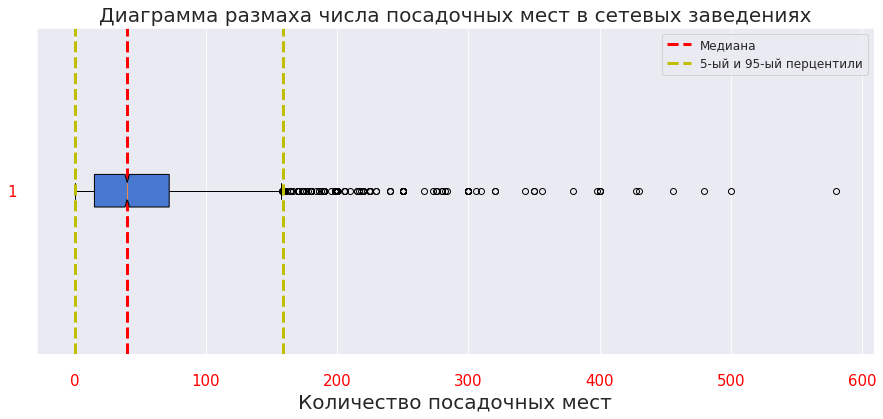

In [17]:
draw_boxplot(
    data=only_chain_data, 
    column='number', 
    title='Диаграмма размаха числа посадочных мест в сетевых заведениях',
    xlabel='Количество посадочных мест'
)

Судя по диаграмме размаха, большинство сетевых заведений имеют от 0 до 150 посадочных мест. Заведения без посадочных мест могут готовить еду на вынос, в то время как заведения с аномально большим количеством мест похожи на выбросы.

In [18]:
only_chain_abnormal_ratio = (
    round(
        only_chain_data.query('number > 200').shape[0] / only_chain_data.shape[0] * 100,
        2
    )
)

print(f'Сетевые заведения с числом посадочных мест, превышающим 200, составляют \
{only_chain_abnormal_ratio}% от всех сетевых заведений.')

abnormal_ratio = (
    round(
        rest_data.query('number > 200').shape[0] / rest_data.shape[0] * 100,
        2
    )
)

print(f'Заведения с числом посадочных мест, превышающим 200, составляют \
{abnormal_ratio}% от всех заведений.')

Сетевые заведения с числом посадочных мест, превышающим 200, составляют 2.24% от всех сетевых заведений.
Заведения с числом посадочных мест, превышающим 200, составляют 5.26% от всех заведений.


Не будем рассматривать такие заведения в дальнейшем исследовании.

In [19]:
only_chain_data = only_chain_data.query('number <= 200')
rest_data = rest_data.query('number <= 200')

In [20]:
grouped_only_chain_data = (
    only_chain_data
    .groupby('object_name', as_index=False)
    .agg({'id': 'count', 'number': 'median'})
    .sort_values(by='id', ascending=False)
    .reset_index(drop=True)
)

grouped_only_chain_data.columns = ['object_name', 'object_amount', 'seat_median']

In [21]:
print('Корреляция числа заведений в сети и количества посадочных мест: {}'
      .format(grouped_only_chain_data['object_amount'].corr(grouped_only_chain_data['seat_median'])))

Корреляция числа заведений в сети и количества посадочных мест: -0.06457199981869242


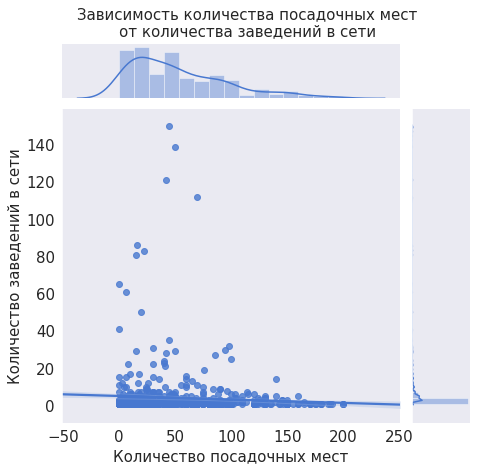

In [22]:
sns.jointplot(
    x='seat_median', 
    y='object_amount', 
    data=grouped_only_chain_data, 
    kind='reg',
    height=6.5
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Зависимость количества посадочных мест\n'
             + 'от количества заведений в сети', 
             fontsize=15)
plt.xlabel('Количество посадочных мест', fontsize=15)
plt.ylabel('Количество заведений в сети', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

In [23]:
print('80-ый перцентиль числа объектов: {:.0f}'
      .format(np.percentile(grouped_only_chain_data['object_amount'], 80)))

80-ый перцентиль числа объектов: 3


In [24]:
print('80-ый перцентиль количества мест: {:.0f}'
      .format(np.percentile(grouped_only_chain_data['seat_median'], 80)))

80-ый перцентиль количества мест: 90


In [25]:
print('Мало заведений с большим количеством посадочных мест: {:.0f} объект'
      .format(grouped_only_chain_data.query('object_amount <= 3 and seat_median > 80').shape[0]))

Мало заведений с большим количеством посадочных мест: 141 объект


In [26]:
print('Много заведений с небольшим числом посадочных мест: {:.0f} объекта'
      .format(grouped_only_chain_data.query('object_amount > 3 and seat_median <= 80').shape[0]))

Много заведений с небольшим числом посадочных мест: 104 объекта


Обусловимся, что «много заведений» — это больше 3, а «много посадочных мест» — больше 80. Явной зависимости между числом заведений в сети и количеством посадочных мест не наблюдается.

### <a id='5'>5. Среднее количество посадочных мест для каждого вида объекта общественного питания</a>

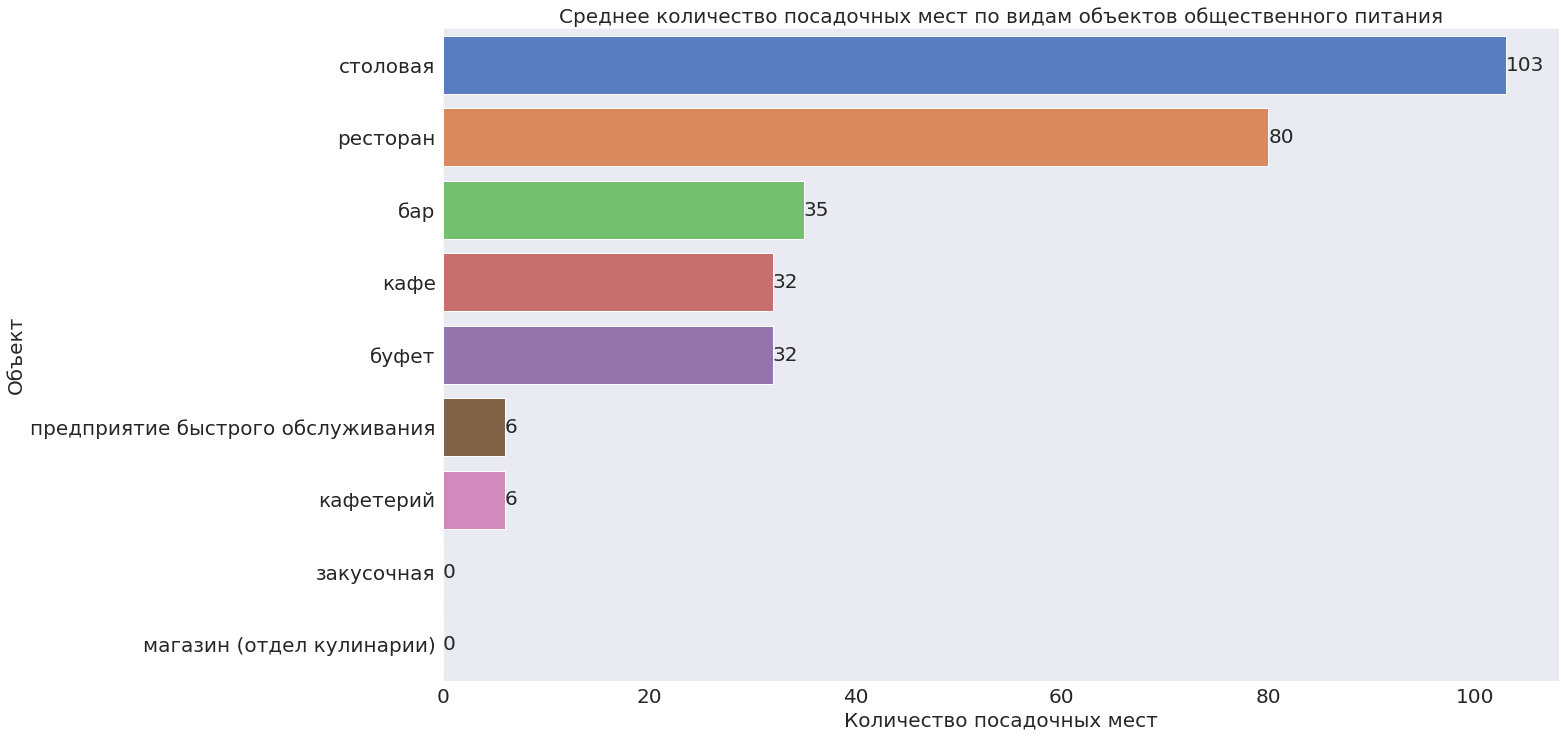

In [27]:
draw_bar(
    data=object_type_data.sort_values(by='seat_median', ascending=False), 
    x='seat_median', 
    y='object_type', 
    title='Среднее количество посадочных мест по видам '
    + 'объектов общественного питания', 
    xlabel='Количество посадочных мест', 
    ylabel='Объект',
    orient='h'
)

В среднестатистической столовой Москвы около 100 посадочных мест. В ресторанах их около 80. В барах, кафе и буфетах 30-35 посадочных мест в среднем.

### <a id='6'>6. Информация об улице</a>

In [28]:
key_words = [
    'аллея', 'бульвар', 'квартал', 'линия',
    'набережная', 'переулок', 'площадь', 'проезд',
    'просек', 'проспект', 'тупик', 'улица', 'шоссе'
]

In [29]:
def get_street(address):
    address = address.split(', ')
    parts = len(address)
    for i in range(parts):
        for key_word in key_words:
            if key_word in address[i]:
                return address[i]

In [30]:
rest_data['street'] = rest_data['address'].apply(get_street)

In [31]:
print('Доля пропусков в столбце с улицами: {:.3f}'
      .format(rest_data['street'].isna().sum() / rest_data.shape[0]))

Доля пропусков в столбце с улицами: 0.025


In [32]:
spreadsheet_id = '1CGcZqlmMJJvwBaasFU-Ogee-seRPTHIPh4ou_GxSOjI'
file_name = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv'
req = requests.get(file_name)
district = pd.read_csv(BytesIO(req.content)).drop('Unnamed: 0', axis=1)
district.columns = ['address', 'district']

In [33]:
rest_data = rest_data.merge(district, how='left', on='address')

In [34]:
print('Доля пропусков в столбце с районами: {:.3f}'
      .format(rest_data['district'].isna().sum() / rest_data.shape[0]))

Доля пропусков в столбце с районами: 0.053


Незначительную часть улиц и районов определить не удалось. Эта часть не должна сильно повлиять на результаты исследования.

### <a id='7'>7. Топ-10 улиц по количеству объектов общественного питания. В каких районах Москвы находятся эти улицы?</a>

In [35]:
top_streets = (
    rest_data
    .groupby('street', as_index=False)
    .agg({'id': 'count'})
    .rename(columns={
        'id': 'object_amount'
    })
    .sort_values(by='object_amount', ascending=False)
    .reset_index(drop=True)
)

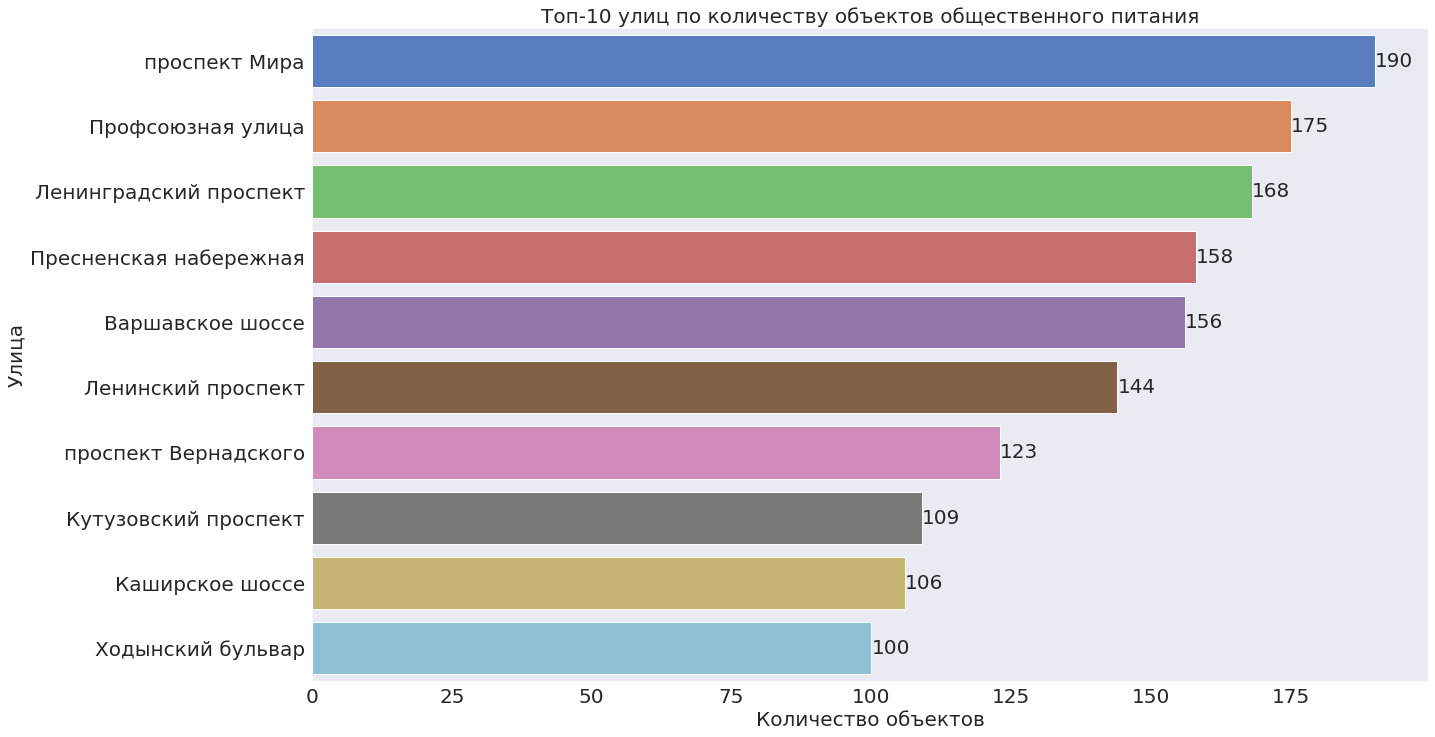

In [36]:
draw_bar(
    data=top_streets.head(10), 
    x='object_amount', 
    y='street', 
    title='Топ-10 улиц по количеству объектов общественного питания', 
    xlabel='Количество объектов', 
    ylabel='Улица',
    orient='h'
)

Больше всего объектов общественного питания расположено на проспекте Мира. Далее с небольшим отставанием следуют Профсоюзная улица, Ленинградский проспект, Пресненская набережная и Варшавское шоссе. Естественно, объектов общественного питания на этих улицах много ещё и засчёт того, что сами улицы очень большие.

In [37]:
top_districts = (
    top_streets.head()
    .merge(rest_data[['street', 'district']], on='street', how='left')
    .drop_duplicates(subset=['street', 'object_amount'])
    .head()
)

top_districts[['street', 'district']].reset_index(drop=True)

,street,district
0,проспект Мира,муниципальный округ Мещанский
1,Профсоюзная улица,муниципальный округ Академический
2,Ленинградский проспект,муниципальный округ Беговой
3,Пресненская набережная,муниципальный округ Пресненский
4,Варшавское шоссе,муниципальный округ Донской


Однозначно определить районы, на которых расположены улицы, не удалось, так как одна улица может проходить через несколько районов. Условно первые пять популярных улиц расположены соответственно в муниципальных округах Мещанский, Академический, Беговой, Пресненский и Донской.

### <a id='8'>8. Число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?</a>

In [38]:
one_object_streets = top_streets.query('object_amount == 1').reset_index(drop=True)

In [39]:
print(f'Число улиц с одним объектом общественного питания: {one_object_streets.shape[0]}')

Число улиц с одним объектом общественного питания: 554


In [40]:
one_object_districts = (
    one_object_streets
    .merge(rest_data[['street', 'district']], on='street', how='left')
    .groupby('district', as_index=False)
    .agg({'street': 'count'})
    .rename(columns={
        'street': 'street_amount'
    })
    .sort_values(by='street_amount', ascending=False)
    .reset_index(drop=True)
    .head()
)

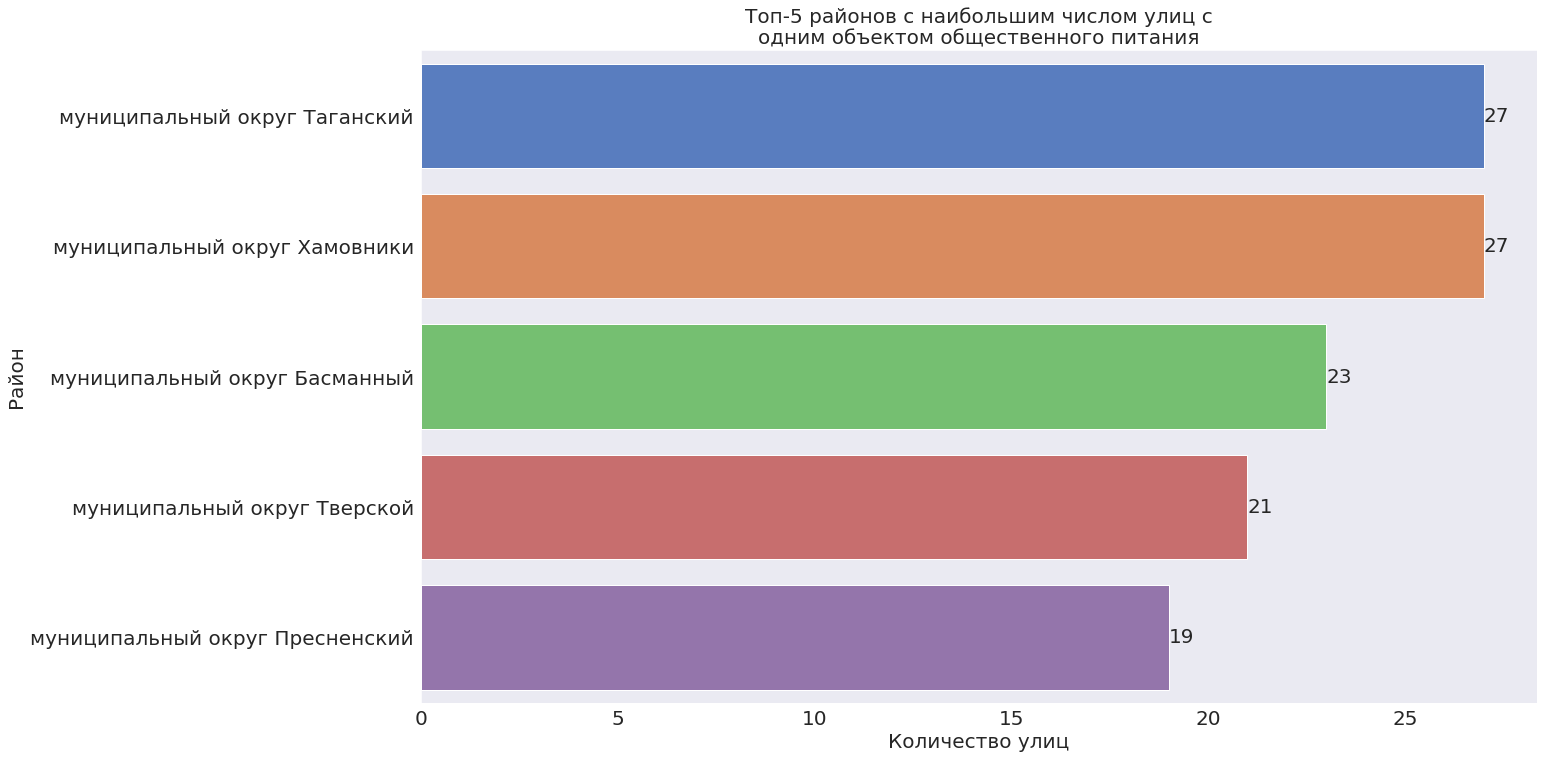

In [41]:
draw_bar(
    data=one_object_districts, 
    x='street_amount', 
    y='district', 
    title='Топ-5 районов с наибольшим числом улиц с\n'
    + 'одним объектом общественного питания', 
    xlabel='Количество улиц', 
    ylabel='Район',
    orient='h'
)

Большинство улиц с одним объектом общественного питания находятся в муниципальных округах Таганский, Хамовники, Басманный, Тверской и Пресненский.

### <a id='9'>9. Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Закономерности</a>

In [42]:
def draw_lines():
    plt.axvline(x=seats_dist.median(),
                linewidth=3,
                color='red',
                linestyle='--')
    plt.axvline(x=seats_dist.quantile(.05),
                linewidth=3, 
                color='y',
                linestyle='--')
    plt.axvline(x=seats_dist.quantile(.95),
                linewidth=3, 
                color='y', 
                linestyle='--')
    plt.legend(labels=['Медиана', '5-ый и 95-ый перцентили'], fontsize=12)

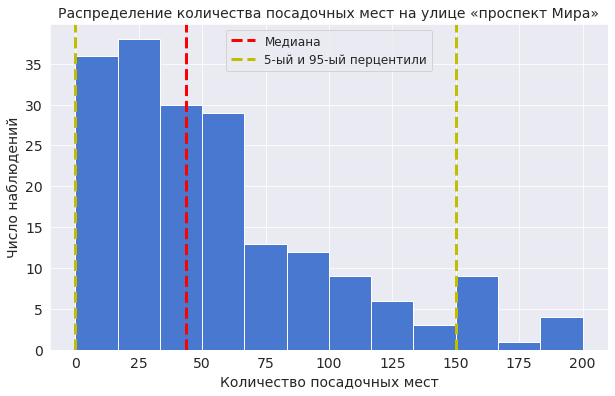

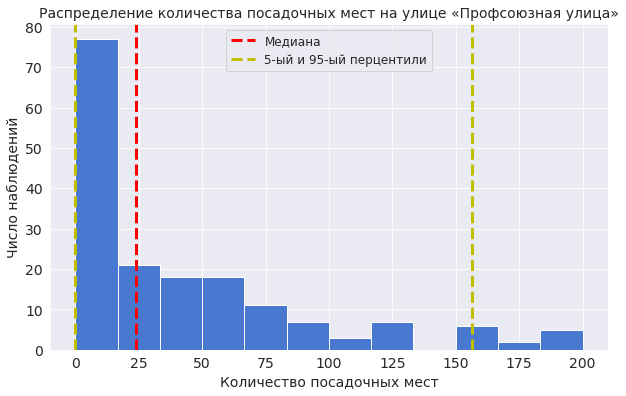

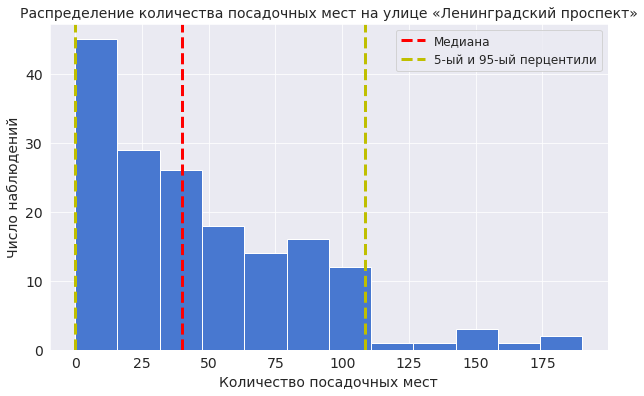

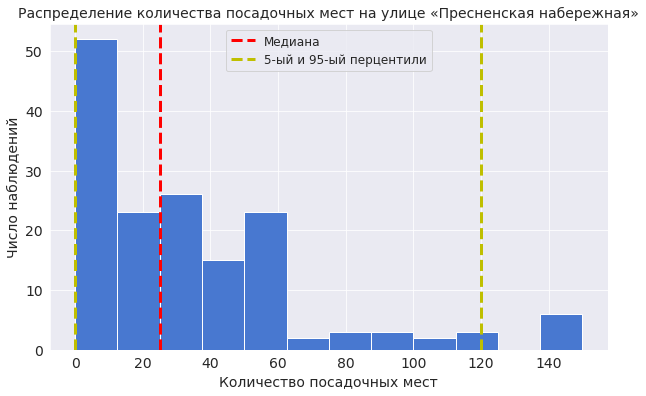

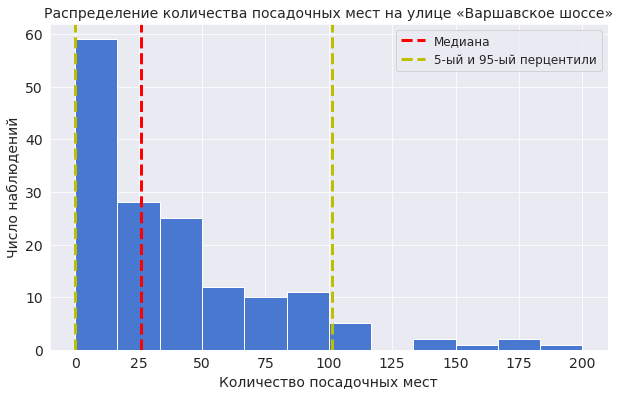

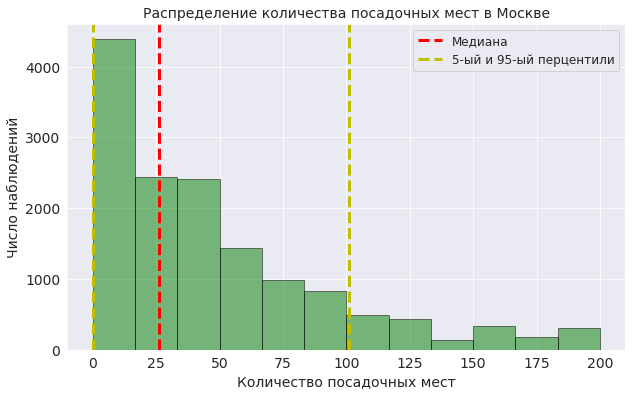

In [43]:
for street in top_streets['street'].head():
    seats_dist = rest_data.query('street == @street')['number']
    plt.figure(figsize=(10, 6))
    seats_dist.hist(bins=12)
    draw_lines()
    plt.title(f'Распределение количества посадочных мест на улице «{street}»', fontsize=14)
    plt.xlabel('Количество посадочных мест', fontsize=14)
    plt.ylabel('Число наблюдений', fontsize=14)
    plt.tick_params(labelsize=14)
    plt.show()

plt.figure(figsize=(10, 6))
rest_data['number'].hist(bins=12, color='green', alpha=0.5, ec='black')
draw_lines()
plt.title('Распределение количества посадочных мест в Москве', fontsize=14)
plt.xlabel('Количество посадочных мест', fontsize=14)
plt.ylabel('Число наблюдений', fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

Медианное значение количества посадочных мест варьируется от 24 до 44 в зависимости от улицы. Закономерно маленьких заведений больше, чем больших.

### Вывод

Кафе — самый популярный объект общественного питания. Их количество превышает 6 000 и составляет почти 40% всех заведений.

Далее располагаются столовые, рестораны и предприятия быстрого обслуживания с показателями 2 572 (17%), 2 272 (15%) и 1 886 (12%) заведений соответственно.

Количество остальных типов объектов не превышает значения в 1 000 (менее 6%).

80% заведений не являются сетевыми.

Предприятия быстрого обслуживания в 41% случаев являются сетевыми. 29% кулинарных магазинов, 23-24% ресторанов и кафе также сетевые. Для остальных объектов общественного питания сетевая распространённость не особо характерна.

Большинство сетевых заведений имеют от 0 до 150 посадочных мест. Заведения без посадочных мест могут готовить еду на вынос, в то время как заведения с аномально большим количеством мест похожи на выбросы.

Сетевые заведения с числом посадочных мест, превышающим 200, составляют 2.24% от всех сетевых заведений. Заведения с числом посадочных мест, превышающим 200, составляют 5.26% от всех заведений. Не будем рассматривать такие заведения в дальнейшем исследовании.

Обусловимся, что «много заведений» — это больше 3, а «много посадочных мест» — больше 80. Явной зависимости между числом заведений в сети и количеством посадочных мест не наблюдается.

В среднестатистической столовой Москвы около 100 посадочных мест. В ресторанах их около 80. В барах, кафе и буфетах 30-35 посадочных мест в среднем.

Больше всего объектов общественного питания расположено на проспекте Мира. Далее с небольшим отставанием следуют Профсоюзная улица, Ленинградский проспект, Пресненская набережная и Варшавское шоссе. Естественно, объектов общественного питания на этих улицах много ещё и засчёт того, что сами улицы очень большие.

Однозначно определить районы, на которых расположены популярные улицы, не удалось, так как одна улица может проходить через несколько районов. Условно первые пять популярных улиц расположены соответственно в муниципальных округах Мещанский, Академический, Беговой, Пресненский и Донской.

Число улиц с одним объектом общественного питания: 554.

Большинство улиц с одним объектом общественного питания находятся в муниципальных округах Таганский, Хамовники, Басманный, Тверской и Пресненский.

Медианное значение количества посадочных мест варьируется от 24 до 44 в зависимости от улицы. Закономерно маленьких заведений больше, чем больших.

## <a id='recommendation'>Шаг 3. Рекомендации</a>

In [44]:
recommended_streets = (
    one_object_streets
    .merge(rest_data[['street', 'district']], on='street', how='left')
    .query('district == "муниципальный округ Пресненский"')
    .reset_index(drop=True)
    .drop('object_amount', axis=1)
)

recommended_streets.columns = ['Улица', 'Район']
recommended_streets.head()

,Улица,Район
0,улица Николаева,муниципальный округ Пресненский
1,улица Подвойского,муниципальный округ Пресненский
2,Средний Кондратьевский переулок,муниципальный округ Пресненский
3,Скатертный переулок,муниципальный округ Пресненский
4,Малый Конюшковский переулок,муниципальный округ Пресненский


Муниципальный округ Пресненский — отличное место для открытия кафе.
1. Заведений в районе достаточно, значит они пользуются спросом.
2. В районе имеются улицы с одним объектом общественного питания. Открыв кафе на одной из таких улиц (например, на улице Николаева), можно избежать жёсткой конкуренции на старте.

Так как проект дорогой, то рентабельнее будет на начальном этапе открыть кафе со средним числом посадочных мест (20-25), чтобы использовать минимальное количество роботов, пока мы не будем убеждены в успешности эксперимента.